(model-reactive-power-comp)=
# Blindstromkompensation modellieren

## Lernziele

<div class="admonition note" style="background: #e5f1ff; padding: 10px">
<div class="title"><b>LERNZIELE</b></div>
    <ul>
        <li> Blindstromkompensation auf Datensatz anwenden </li>
        <li> mithilfe von Annahmen über den Leistungsfaktor </li>
        <li> um den Effekt auf elektrische Energieeffizienz zu quantifizieren </li>
    </ul>
</div>

## python konfigurieren

### Module importieren

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import locale
import schemdraw
import schemdraw.elements as elm
from distutils.spawn import find_executable

print('Versionen der verwendeten python-Module: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('os', os)
print('locale', locale)
print('schemdraw', schemdraw.__version__)

Versionen der verwendeten python-Module: 
numpy 1.21.5
matplotlib 3.5.2
pandas 1.4.4
datetime <module 'datetime' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/datetime.py'>
os <module 'os' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/os.py'>
locale <module 'locale' from '/home/franzi/.pyenv/versions/miniconda-latest/envs/22sye/lib/python3.10/locale.py'>
schemdraw 0.15


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
locale.setlocale(locale.LC_ALL, '')
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

if find_executable('latex'):
    plt.rcParams['text.usetex'] = True
    pd.set_option('display.latex.repr', True)
    pd.set_option('display.latex.longtable', True)

### Funktionen definieren

In [3]:
def read_energy_logger_file(path_to_file):

    # Check if path exists
    if not os.path.exists(path_to_file) or not os.path.isfile(path_to_file):
        raise Exception("No file at given path!")
        
    # Read data into pandas dataframe
    df = pd.read_csv(path_to_file, header = 7)

    # Rename columns
    df = df.rename(columns = {"Aufnahmezeit": "timestamp", "Stromstärke (A)": "Current [A]", "Wirkleistung (W)": "Active Power [W]", "Scheinleistung (W)": "Apparent Power [VA]"})

    # Since the data provided by the energy logger
    # is not formated correctly for further usage,
    # each cell needs to be reformated.

    # Iterate through dataframe and reformat data
    for index, row in df.iterrows():
        
        # Reformat other columns
        for column in df.columns:
            if not column == "timestamp":
                
                # Get string from cell
                string = row[column].replace(",", ".")

                # Create float from string
                value = float(string)
                
                # Set reformated cell
                row[column] = value

    # Cast data types to float 64
    for column in df.columns:
        if not column == "timestamp":
            df = df.astype({column: 'float64'})
            
            
    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

In [4]:
def read_energy_logger_file(path_to_file):

    # Check if path exists
    if not os.path.exists(path_to_file) or not os.path.isfile(path_to_file):
        raise Exception("No file at given path!")
        
    # Read data into pandas dataframe
    df = pd.read_csv(path_to_file, header = 7)

    # Rename columns
    df = df.rename(columns = {"Aufnahmezeit": "timestamp", "Stromstärke (A)": "Current [A]", "Wirkleistung (W)": "Active Power [W]", "Scheinleistung (W)": "Apparent Power [VA]"})

    # Since the data provided by the energy logger
    # is not formated correctly for further usage,
    # each cell needs to be reformated.

    # Iterate through dataframe and reformat data
    for index, row in df.iterrows():
        
        # Reformat other columns
        for column in df.columns:
            if not column == "timestamp":
                
                # Get string from cell
                string = row[column].replace(",", ".")

                # Create float from string
                value = float(string)
                
                # Set reformated cell
                row[column] = value

    # Cast data types to float 64
    for column in df.columns:
        if not column == "timestamp":
            df = df.astype({column: 'float64'})
            
            
    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

In [5]:
def map_timestamp(df, start_timestamp_string, resolution = 1, column_name = "timestamp"):
    
    # Create datetime object from start timestamp
    start_timestamp = dt.datetime.strptime(start_timestamp_string, "%d-%m-%Y %H:%M:%S")
    
    timestamps = []
    
    # Iterate through data frame rows
    for idx, row in df.iterrows():
        
        # Create mapped timestamp
        mapped_timestamp = start_timestamp + dt.timedelta(minutes = len(timestamps) * resolution)
        
        # Append timestamp
        timestamps.append(mapped_timestamp)
        
    
    df[column_name] = timestamps
    
    
    # Return mapped data frame
    return df

In [6]:
def create_uniform_dataframe(size, value):
    values = []
    
    for i in range(0, size):
        values.append(value)
    
    timestamps = ["01-01-2019 00:00:00" for x in range(size)]

    df = pd.DataFrame()
    
    df["timestamp"] = timestamps
    df["Current [A]"] = values
    df["Active Power [W]"] = values
    df["Apparent Power [VA]"] = values

    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

In [7]:
def concat_data(dfs):
    
    # dfs in tuple-format: (dataFrame, startTimestamp)
    
    # Prepare data frames
    dfsToConcat = []
    
    # Set timestamps
    for df in dfs:
        mapped_df = map_timestamp(df[0], df[1])
        dfsToConcat.append(mapped_df.copy())
        
    return pd.concat(dfsToConcat)

In [8]:
def timestamp_based_concat(df, start_timestamp_string, number_of_concats, offset):
    result = []
    
    # Create datetime object from start timestamp
    start_timestamp = dt.datetime.strptime(start_timestamp_string, "%d-%m-%Y %H:%M:%S")

    for i in range(0, number_of_concats):
        
        timestamp = start_timestamp + dt.timedelta(minutes = offset * i)
        timestamp_string = timestamp.strftime("%d-%m-%Y %H:%M:%S")
        
        result.append((df.copy(), timestamp_string))
        
    return result

## Referenzdatensatz aus vorigem Abschnitt

Der Beispieldatensatz ist der Datensatz aus dem [Abschnitt](gen-ref) (jupyter notebook unter `files/08/SYE-generate-reference.ipynb`).

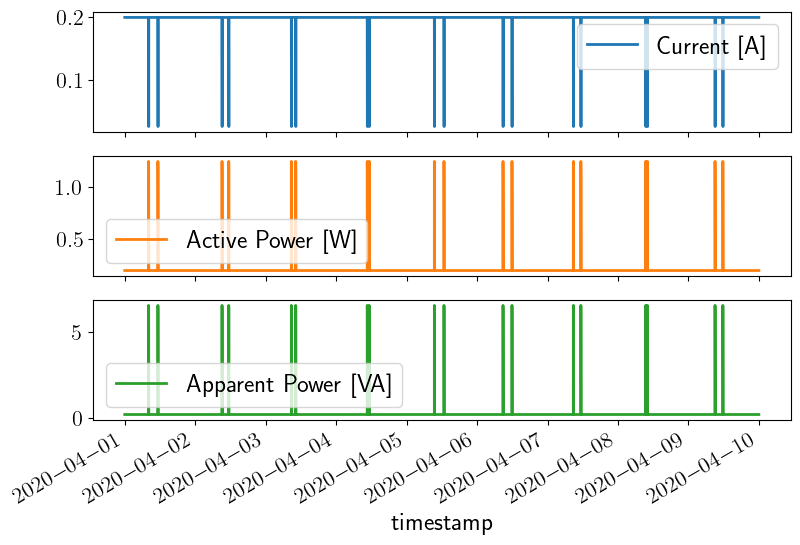

In [9]:
examplemeas = read_energy_logger_file('../data/Energieloggertestdaten.csv')
examplestandby = .2 # Watt
examplestandbydf = create_uniform_dataframe(1,examplestandby)
no_days = 10 # number of days
start_date = dt.datetime.strptime("01-04-2020 00:00:00", "%d-%m-%Y %H:%M:%S")
duration = 24*60*(no_days-1) # minutes in a day during no_days
exampledata = timestamp_based_concat(examplestandbydf, start_date.strftime("%d-%m-%Y %H:%M:%S"), duration, 1)
for x in range(no_days-1): 
    tmp_date = start_date + dt.timedelta(days = x, hours = 9+np.random.randn(1)[0])
    tmp_date2 = start_date + dt.timedelta(days = x, hours = 11.5+np.random.randn(1)[0])
    exampledata.extend(timestamp_based_concat(examplemeas, tmp_date.strftime("%d-%m-%Y %H:%M:%S"), 1, 1))
    exampledata.extend(timestamp_based_concat(examplemeas, tmp_date2.strftime("%d-%m-%Y %H:%M:%S"), 1, 1))
exampledatadf = concat_data(exampledata)
exampledatadf = exampledatadf.set_index('timestamp')
exampledatadf.plot(subplots=True, figsize=(9,6))
plt.show()

Beim Beispieldatensatz ist nicht bekannt, ob es sich um einen Ohmsch-induktiven oder einen Ohmsch-kapazitiven Verbraucher handelt. Im folgenden werden beide Möglichkeiten beschrieben.

## Ohmsch-induktiven Verbraucher kompensieren

Falls es sich um einen Ohmsch-induktiven Verbraucher handelt, dann sieht das elektrische Ersatzschaltbild folgendermaßen aus:

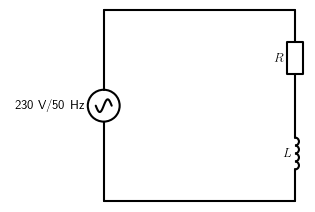

In [10]:
d = schemdraw.Drawing()
d.add(elm.LINE, d='right',l=6)
d.add(elm.RBOX, d='down', label='$R$')
d.add(elm.INDUCTOR,d='down',label='$L$')
d.add(elm.LINE, d='left',l=6)
d.add(elm.SOURCE_SIN, d='up', label='230 V/50 Hz',l=6)
d.draw()

Der Ohmsche Anteil der Last $R$ sorgt für das Wirkleistungsprofil $P(t)$. Der induktive Anteil der Last $L$ sorgt für das Blindleistungsprofil $Q(t) = \sqrt{S^2 - P^2}$. Der Leistungsfaktor der Last beträgt zeitabhängig $\cos\varphi(t) = \frac{P(t)}{S(t)}$.

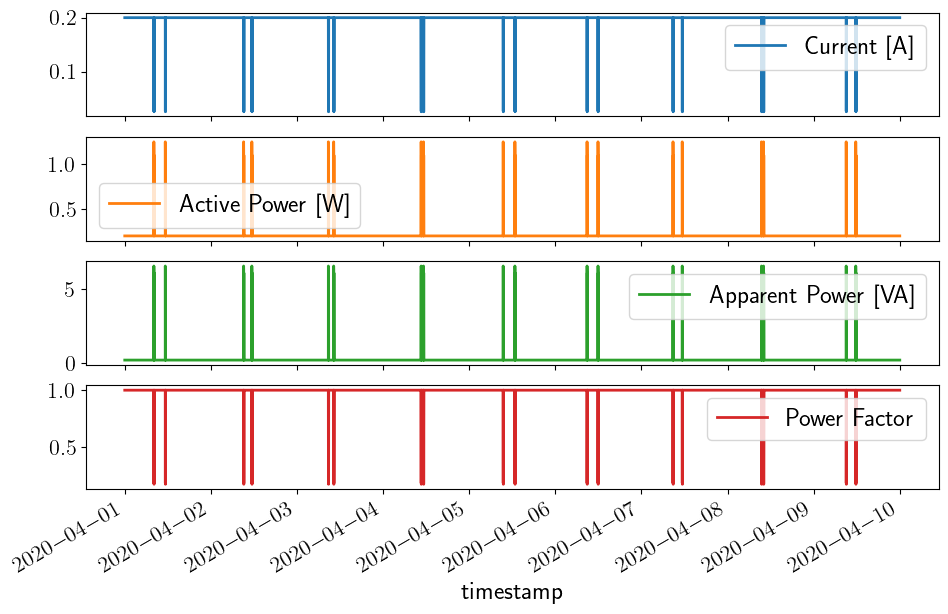

In [11]:
exampledatadf['Power Factor'] = exampledatadf['Active Power [W]']/exampledatadf['Apparent Power [VA]']
exampledatadf.plot(subplots=True, figsize=(11,7))
plt.show()

Durch Einsatz eines Kondensators lässt sich der Blindstrom eines Ohmsch-Induktiven Verbrauchers **kompensieren**:

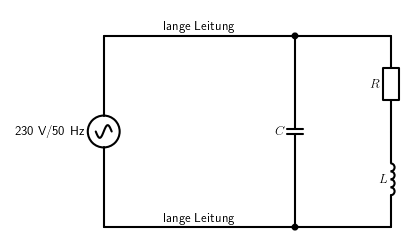

In [12]:
d = schemdraw.Drawing()
d.add(elm.LINE, d='right',label='lange Leitung',l=6)
d.add(elm.DOT)
d.push()
d.add(elm.LINE, d='right')
d.add(elm.RBOX, d='down', label='$R$')
d.add(elm.INDUCTOR,d='down',label='$L$')
d.add(elm.LINE, d='left')
d.add(elm.DOT)
d.add(elm.LINE, d='left',l=6,label='lange Leitung')
d.add(elm.SOURCE_SIN, d='up', label='230 V/50 Hz',l=6)
d.pop()
d.add(elm.CAP, d='down', l=6, label='$C$')
d.draw()

Dadurch sinkt der Blindstromanteil, auf den Leitungen und an der Spannungsquelle und es sinken dort die Ohmschen Verluste. Denn der Blindstrom schwingt jetzt nicht mehr im ganzen System hin- und her, sondern nur noch zwischen Induktivität und Kondensator. Häufig findet dies Anwendung bei Elektromotoren, Leuchtstofflampen, ...

In erster Näherung lässt sich modellieren, dass der Leistungsfaktor nach der Kompensation mindestens z.B. $\cos\varphi_c = 0,9$ beträgt.

In [13]:
newcosphi = 0.9
tmp = np.array(exampledatadf['Power Factor'].values.tolist())
exampledatadf['Power Factor after Compensation'] = np.where(tmp < 0.9, 0.9, tmp).tolist()

Die Wirkleistung $P$ bleibt gleich, denn die mechanische, thermische, optische, ... Leistung, die aus der elektrischen Leistung gewandelt werden soll, wird nach wie vor benötigt.

Jedoch reduziert diese Maßnahme die Blindleistung auf $Q_c$ und damit auch die Scheinleistung auf $S_c$ nach der Kompensation.

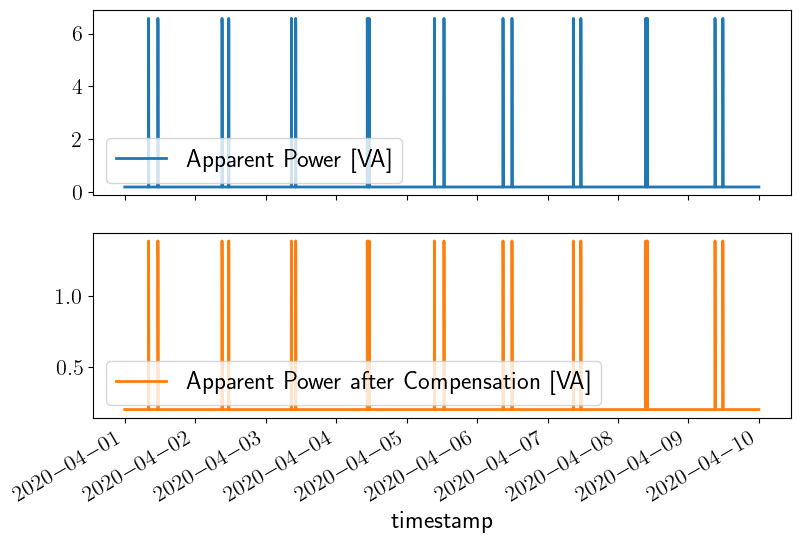

In [14]:
exampledatadf['Apparent Power after Compensation [VA]'] = exampledatadf['Active Power [W]']/exampledatadf['Power Factor after Compensation']
exampledatadf.plot(subplots=True,y=['Apparent Power [VA]','Apparent Power after Compensation [VA]'], figsize=(9,6))
plt.show()

Das bedeutet, dass sich auch der Blindstrom entsprechend reduziert auf $I_c = S_c/U$.

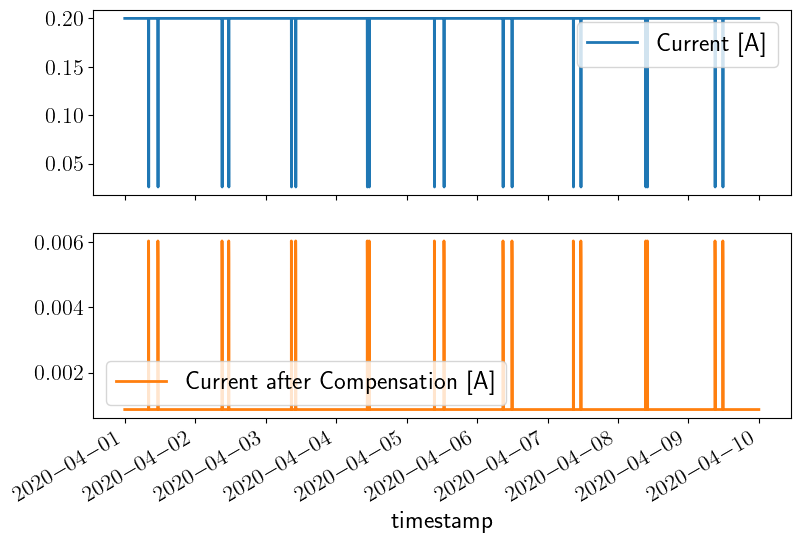

In [15]:
U = 230 # V
exampledatadf['Current after Compensation [A]'] = exampledatadf['Apparent Power after Compensation [VA]']/U
exampledatadf.plot(subplots=True,y=['Current [A]','Current after Compensation [A]'], figsize=(9,6))
plt.show()

Auf den langen Leitung mit Leitungswiderstand $R_L$ reduzieren sich dadurch die Ohmschen Verluste von $P_V = I^2 \cdot R_L$ auf $P_{V,c} = I_c^2 \cdot R_L$.

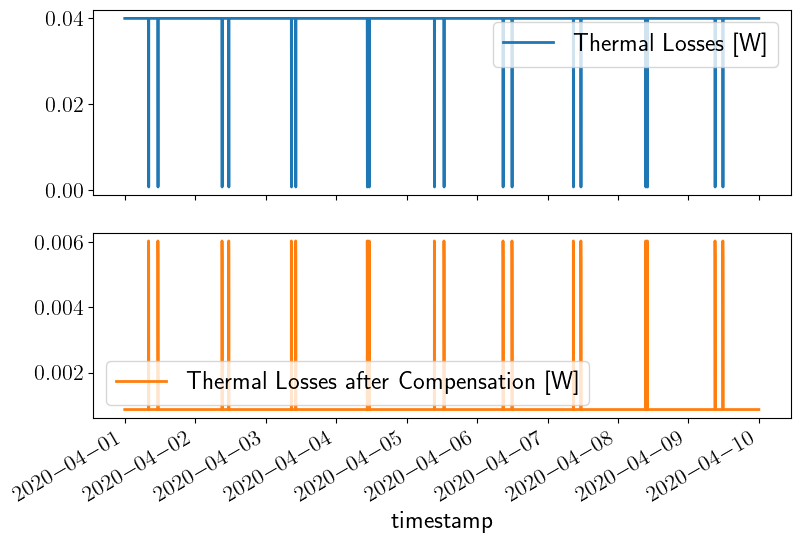

In [16]:
RL = 1 # Ohm - ggf. extra berechnen
exampledatadf['Thermal Losses [W]'] = RL*exampledatadf['Current [A]']**2
exampledatadf['Thermal Losses after Compensation [W]'] = RL*exampledatadf['Current after Compensation [A]']
exampledatadf.plot(subplots=True,y=['Thermal Losses [W]','Thermal Losses after Compensation [W]'], figsize=(9,6))
plt.show()

Über den betrachteten Zeitraum bringt diese Maßnahme also eine Einsparung:

In [17]:
Eloss = 60*exampledatadf['Thermal Losses [W]'].sum()
print('before Compensation:'+str(np.round(Eloss,2))+' J')
print(str(np.round(Eloss/(60*60),2))+' Wh')
Elossc = 60*exampledatadf['Thermal Losses after Compensation [W]'].sum()
print('after Compensation:'+str(np.round(Elossc,2))+' J')
print(str(np.round(Elossc/(60*60),2))+' Wh')

before Compensation:31107.88 J
8.64 Wh
after Compensation:705.74 J
0.2 Wh


## Ohmsch-kapazitiven Verbraucher kompensieren

Falls es sich um einen Ohmsch-kapazitiven Verbraucher handelt, dann sieht das elektrische Ersatzschaltbild folgendermaßen aus:

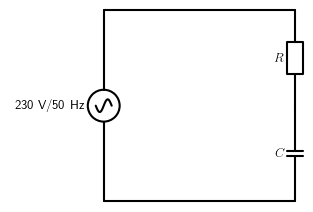

In [18]:
d = schemdraw.Drawing()
d.add(elm.LINE, d='right',l=6)
d.add(elm.RBOX, d='down', label='$R$')
d.add(elm.CAP,d='down',label='$C$')
d.add(elm.LINE, d='left',l=6)
d.add(elm.SOURCE_SIN, d='up', label='230 V/50 Hz',l=6)
d.draw()

Der Ohmsche Anteil der Last $R$ sorgt für das Wirkleistungsprofil $P(t)$. Der kapazitive Anteil der Last $C$ sorgt für das Blindleistungsprofil $Q(t) = \sqrt{S^2 - P^2}$. Der Leistungsfaktor der Last beträgt zeitabhängig $\cos\varphi(t) = \frac{P(t)}{S(t)}$. Da $\cos\varphi = \cos(-\varphi)$ ergibt sich im Weiteren derselbe Rechenweg wie beim Ohmsch-induktiven Verbraucher.

Hier kompensiert eine Induktivität den Ohmsch-kapazitiven Verbraucher:

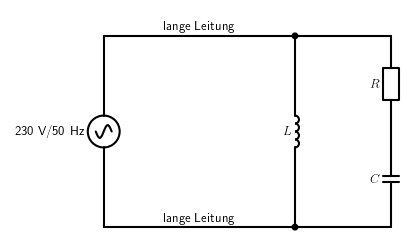

In [19]:
d = schemdraw.Drawing()
d.add(elm.LINE, d='right',label='lange Leitung',l=6)
d.add(elm.DOT)
d.push()
d.add(elm.LINE, d='right')
d.add(elm.RBOX, d='down', label='$R$')
d.add(elm.CAP,d='down',label='$C$')
d.add(elm.LINE, d='left')
d.add(elm.DOT)
d.add(elm.LINE, d='left',l=6,label='lange Leitung')
d.add(elm.SOURCE_SIN, d='up', label='230 V/50 Hz',l=6)
d.pop()
d.add(elm.INDUCTOR, d='down', l=6, label='$L$')
d.draw()

Dadurch sinkt der Blindstromanteil, auf den Leitungen und an der Spannungsquelle und es sinken dort die Ohmschen Verluste. Denn der Blindstrom schwingt jetzt nicht mehr im ganzen System hin- und her, sondern nur noch zwischen Induktivität und Kondensator. Kapazitive Verbraucher sind häufig Netzteile (z. B. von Computern). Deren Blindleistung besteht nicht nur aus der Feldblindleistung $Q$, sondern auch aus der Verzerrungsblindleistung $D$. Unser Modell funktioniert trotzdem, da wir hier außen vorlassen, wie die Kompensation technisch im Detail aussieht.

### Verzerrungsblindleistung reduzieren

- Ziel: Leistungsfaktor $\lambda\to1$, um andere Geräte nicht zu stören (EMV = elektromagnetische Verträglichkeit)
- $\lambda = \frac{P}{S} = \frac{P}{\sqrt{P^2 + Q^2 + D^2 }}$
- Leistungsfaktorkorrekturfilter (engl. PFC power factor control) ab 75 W Pflicht
 - passiv (mit Spulen und Kondensatoren): bis ca. 200 W sinnvoll, $\lambda \approx 0,7 ..0,8$
 - aktiv (mit aktiven Halbleitern wie Transistoren): über 200 W, $\lambda\approx0,98$
- Häufige Beispiele: Schaltnetzteile

Modellierung: wie oben mit $\lambda_{vorher}$ und $\lambda_{nachher}$ statt $\cos\varphi$ und $\cos\varphi_c$.

```{bibliography}
:filter: docname in docnames
```